In [1]:
import numpy as np 
import networkx as nx 
import matplotlib.pyplot as plt

import networkx.generators.random_graphs as rg
import math

import collections
from networkx.generators.random_graphs import watts_strogatz_graph as ws
import itertools


# Preliminary parts

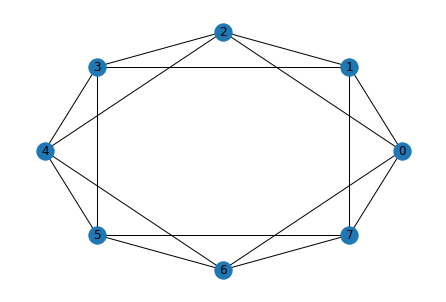

In [2]:
G = nx.Graph()
k = 4
n = 8
for i in range(n-2):
    G.add_edge(i, i+1)
    G.add_edge(i, i+2)
G.add_edge(n-2, n-1)
G.add_edge(n-2, 0)
G.add_edge(n-1, 0)
G.add_edge(n-1, 1)

nx.draw_circular(G, with_labels = True)
plt.savefig("k_reg.eps",format='eps')

In [3]:
def sim_SIR_epidemic(G, n_weeks = 5, initial_states = 'random', random_sick = 3, beta = 0.3, rho = 0.7, until_end = True):
    '''
    G: networkx.classes.graph.Graph, graph
    n_weeks: int, number of simulation weeks
    initial_states: list, initial state of agents or default 'random' initialize sick people randomly
    random_sick: int, how many sick agents if initial state is randomly generated, default 3
    beta: float, the probability that the infection is spread from an infected individual to a susceptible one, default 0.3
    rho: float, the probability that an infected individual will recover, default 0.7
    until_end: boolean, indicates whether the simulation continues until the end or finishes after we reach zero infected individuals
    '''

    # Number of people
    n_agents = len(G)

    A_ = [0,1,2] # 0-S, 1-I, 2-R

    states = [0 for _ in range(n_agents)] # 0-S, 1-I, 2-R

    if initial_states == 'random':
        choices = np.random.choice(G.nodes(),size = random_sick, replace= False)
        for i in choices:
            states[i] = 1
        initial_states = states.copy()

    old_states = initial_states.copy()
#     print('Initial states of agents: {}'.format(initial_states))

    W = nx.convert_matrix.to_numpy_matrix(G)

    weeks = []
    weeks.append(initial_states.copy())
    
    newly_infected_list = [1]
    for week in range(n_weeks):  
        if not until_end:
            if not 1 in states:
                #print('No one is sick! \nGREAT SUCCESS!')
                break

#         print("States: {}, \nWeek: {}".format(states, week+1))
        newly_infected = 0
        for agent in range(n_agents):
            # if S:
            if old_states[agent] == 0:
                ngh_states = np.squeeze(np.asarray(W[agent]))*old_states # get neighbors' statuses
                m = collections.Counter(ngh_states)[1] # count sick neighbors 

                if np.random.rand() < (1-(1-beta)**m):
                    states[agent] = 1 # get sick
                    newly_infected += 1
            # if I:
            elif old_states[agent] == 1:
                if np.random.rand() < rho:
                    states[agent] = 2 # get recovered
        
        weeks.append(states.copy())
        newly_infected_list.append(newly_infected)
        
        old_states = states.copy()
#         print(old_states)
    return weeks, newly_infected_list
        # weeks = weeks[:5]

In [4]:
def get_sir_count(weeks):
    '''
    weeks: list, list of states through weeks
    '''
    susceptibles = [collections.Counter(np.asarray(w))[0] for w in weeks]
    infected = [collections.Counter(np.asarray(w))[1] for w in weeks]
    recovered = [collections.Counter(np.asarray(w))[2] for w in weeks]
    #print('susceptibles: {}, \ninfected: {}, \nrecovered: {}'.format(susceptibles, infected, recovered))
    return susceptibles, infected, recovered

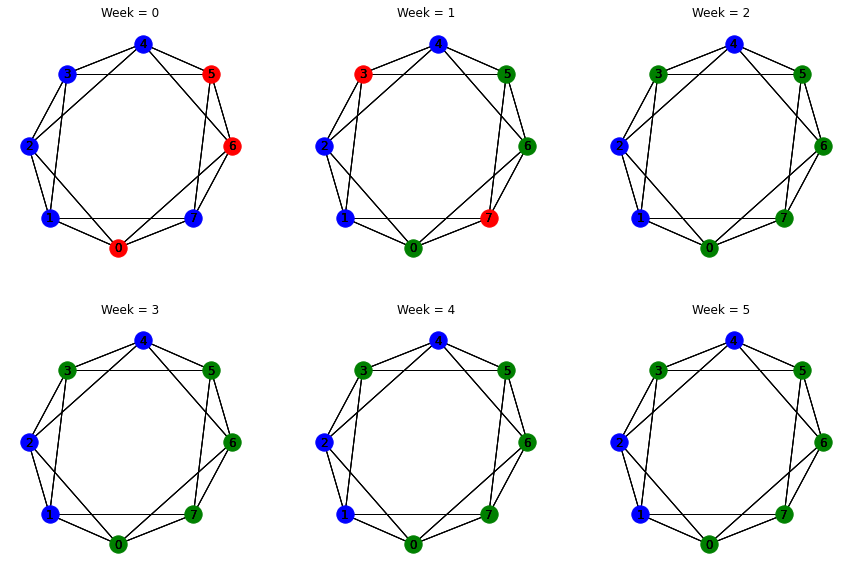

In [5]:
weeks, newly_infected_list = sim_SIR_epidemic(G, n_weeks=5, initial_states='random', random_sick=3,beta=0.3, rho=0.7, until_end=True)
# Plot the infection spread
pos = nx.spectral_layout(G)
fig = plt.figure(figsize=(15,10))
for t in range(0,len(weeks)):
    plt.subplot(2,3,t+1)
    week = weeks[t]
    
    x = np.array(week.copy())
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'b')
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'r')
    nx.draw_spectral(G,
        with_labels=True,
        nodelist=np.argwhere(x==2).T[0].tolist(),
        node_color = 'g')
    plt.title('Week = {0}'.format(t))
susceptibles, infected, recovered = get_sir_count(weeks)


# Problem 1.1

## Random Initial Condition

In [15]:
G = nx.Graph()
k = 4
n = 500
for i in range(n-2):
    G.add_edge(i, i+1)
    G.add_edge(i, i+2)
G.add_edge(n-2, n-1)
G.add_edge(n-2, 0)
G.add_edge(n-1, 0)
G.add_edge(n-1, 1)


N = 100
sus_list = []
inf_list = []
rec_list = []
new_inf_list = []
for n in range(N):
    # print("Simulation #{}".format(n+1))
    weeks, newly_infected_list = sim_SIR_epidemic(G, n_weeks=15, initial_states='random', random_sick=10, beta=0.3, rho=0.7) 
    susceptibles, infected, recovered = get_sir_count(weeks)
    # print('newly infected: {}\n'.format(newly_infected_list))
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    new_inf_list.append(newly_infected_list)
new_inf_list = np.array(new_inf_list)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


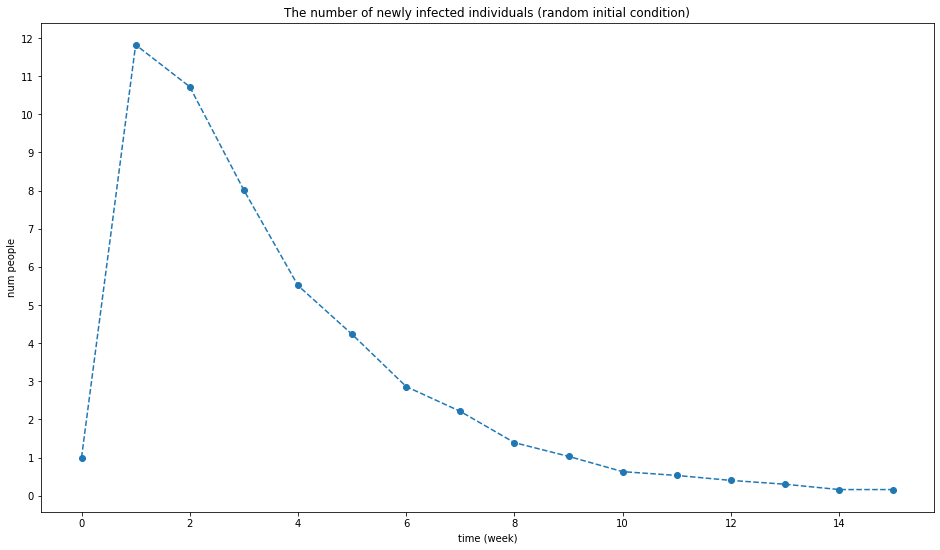

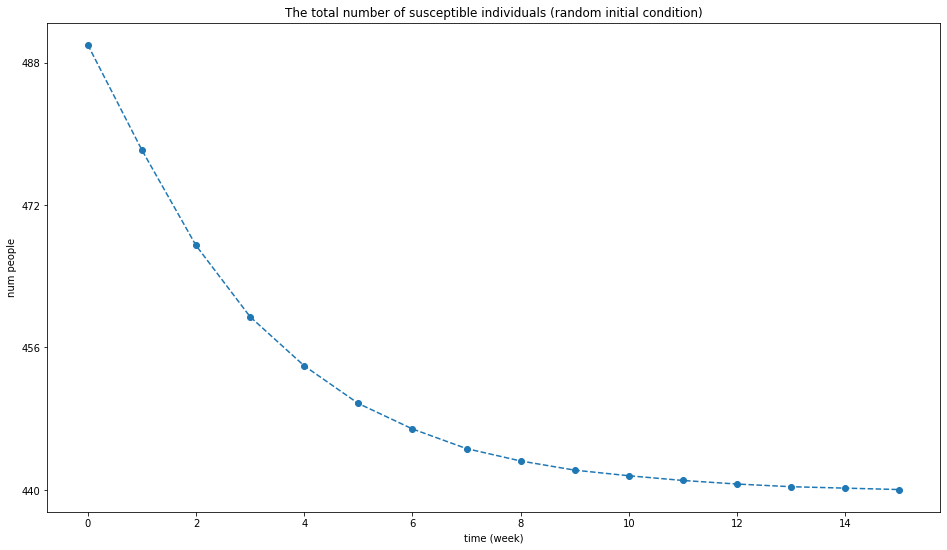

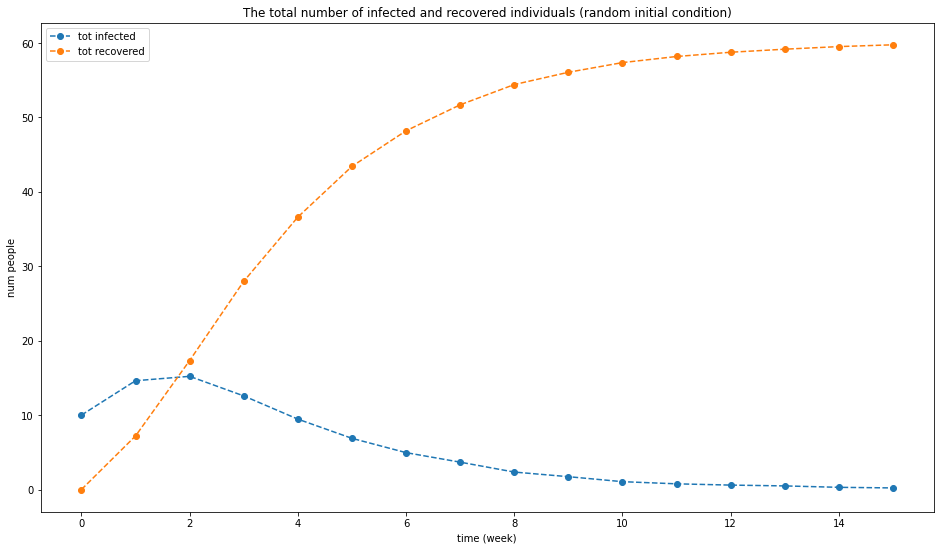

In [16]:
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
ax.set_yticks(yint)
ax.set_title("The number of newly infected individuals (random initial condition)")
plt.savefig("new_inf.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot avg sus',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1, len(avg_sus))
ax.set_yticks(yint)
ax.set_title("The total number of susceptible individuals (random initial condition)")
plt.savefig("tot_sus.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (random initial condition)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf.eps",format='eps')

## Realistic Initial Condition

In [17]:
G = nx.Graph()
k = 4
n = 500
for i in range(n-2):
    G.add_edge(i, i+1)
    G.add_edge(i, i+2)
G.add_edge(n-2, n-1)
G.add_edge(n-2, 0)
G.add_edge(n-1, 0)
G.add_edge(n-1, 1)

sus_list = []
inf_list = []
rec_list = []
new_inf_list = []

init_inf = [0]*n
for i in range(8):
    init_inf[i] = 1

N = 100

for i in range(N):
    # print("Simulation #{}".format(i+1))
    weeks, newly_infected_list = sim_SIR_epidemic(G, n_weeks=15, initial_states=init_inf, random_sick=10, beta=0.3, rho=0.7) 
    susceptibles, infected, recovered = get_sir_count(weeks)
    # print('newly infected: {}\n'.format(newly_infected_list))
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    new_inf_list.append(newly_infected_list)
new_inf_list = np.array(new_inf_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


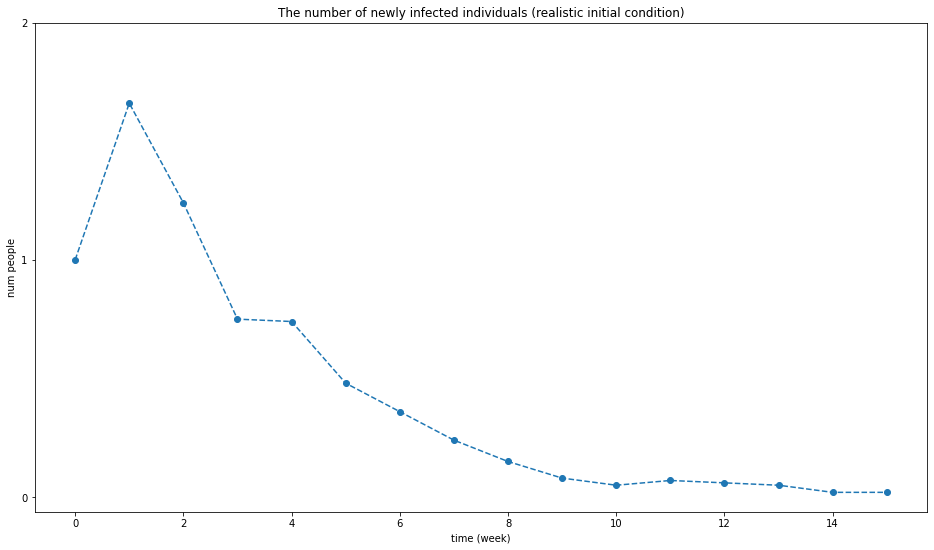

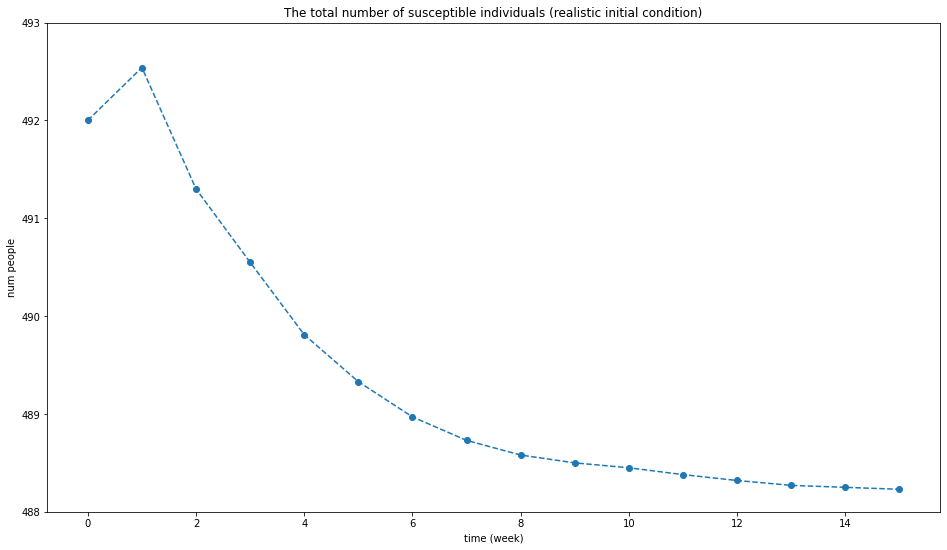

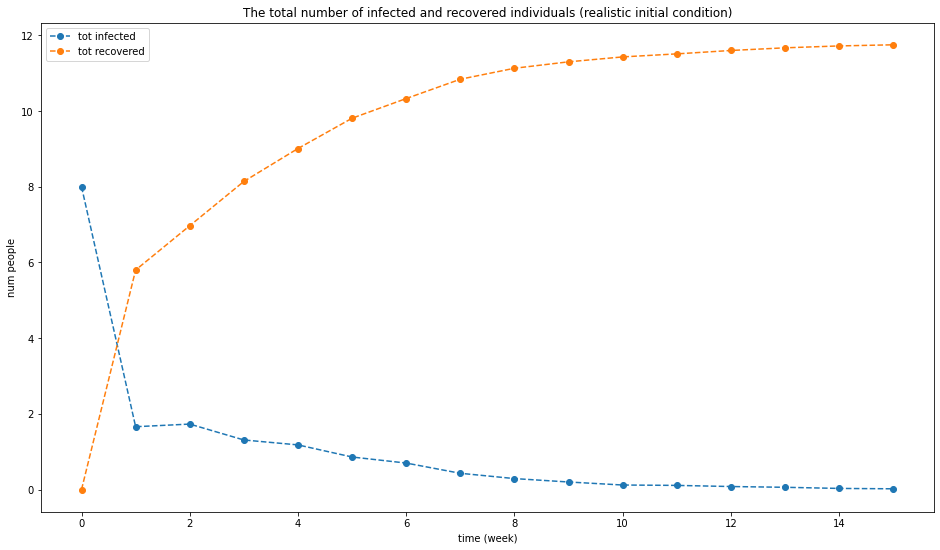

In [18]:
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
ax.set_yticks(yint)
ax.set_title("The number of newly infected individuals (realistic initial condition)")
plt.savefig("new_inf_real.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot avg sus',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
ax.set_yticks(yint)
ax.set_title("The total number of susceptible individuals (realistic initial condition)")
plt.savefig("tot_sus_real.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (realistic initial condition)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_real.eps",format='eps')


# Problem 1.2

In [19]:
def generate_graph(k, n_nodes, verbose = False):
    '''
    k: int, average degree
    n_nodes: int, number of nodes
    verbose: boolean, for printing information
    '''
    t = 1
    G = nx.random_graphs.complete_graph(k+1) # generate an initial complete graph with k+1 nodes
#     nx.draw_circular(G)
    while 1:
        degrees = [deg for (node, deg) in G.degree()] # degree of nodes
        prob = [d/sum(degrees) for d in degrees]
        sel_nodes = np.random.choice(list(G.nodes), size=int((k+(-1)**(t*k))/2), p=prob, replace = False) # size alternate between floor and ceil when k is odd
        G.add_edges_from([(G.number_of_nodes(), n) for n in sel_nodes]) # add edge from n+1 to k/2 number of nodes
#         G.add_edge(len(G.nodes()), sel_nodes)
        avg_deg = 2*G.number_of_edges() / float(G.number_of_nodes())
#         print("Time:", t,"\nAvg degree:", avg_deg)
        
        t += 1
        if G.number_of_nodes() == n_nodes:
            break
#     nx.draw_circular(G)
    if verbose:
        print('Graph with {} nodes and {} degree is created using preferential attachment.'.format(n_nodes, k))
    return G
    

The average degree of nodes: 6.0


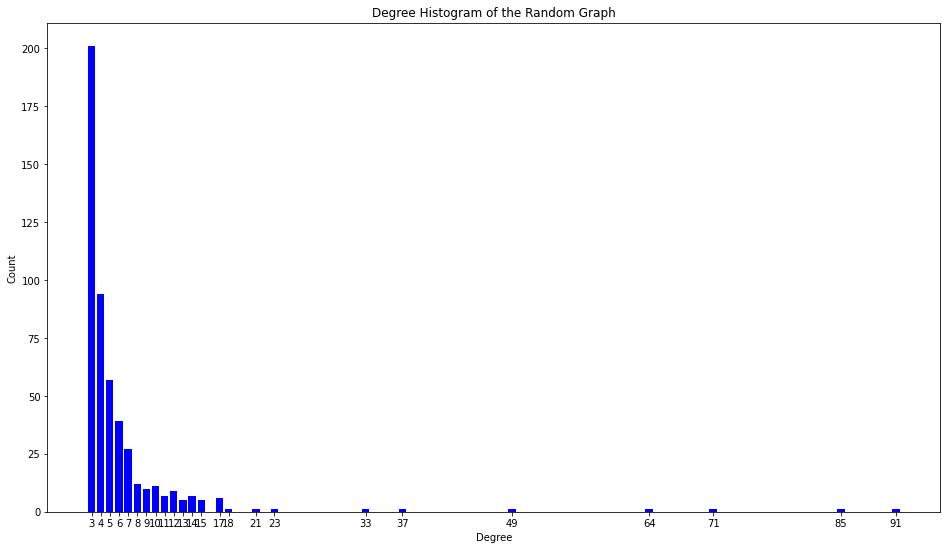

In [20]:
k = 6
N = 500

G = generate_graph(k,N, verbose=False)
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(deg, cnt, width=0.80, color='b')

ax.set_title("Degree Histogram of the Random Graph")
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)
degs = list(dict(G.degree()).values())
print("The average degree of nodes:", np.mean(np.array(degs)))
plt.savefig("deg_hist.eps",format='eps')


# Problem 2

## Random Initial Condition

In [21]:
sus_list = []
inf_list = []
rec_list = []
new_inf_list = []

k = 6
beta = 0.3
rho = 0.7
n=500
G2 = generate_graph(k,n, verbose=False)

N = 100
for i in range(N):
    #print("Simulation #{}".format(i+1))
    weeks, newly_infected_list = sim_SIR_epidemic(G2, n_weeks=15, initial_states='random', random_sick=10, beta=beta, rho=rho) 
    susceptibles, infected, recovered = get_sir_count(weeks)
    #print('newly infected: {}\n'.format(newly_infected_list))
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    new_inf_list.append(newly_infected_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


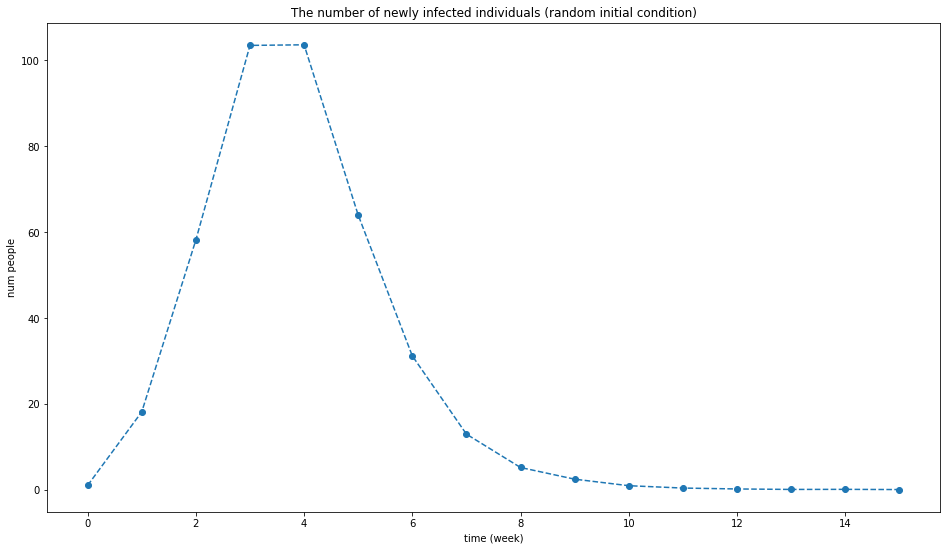

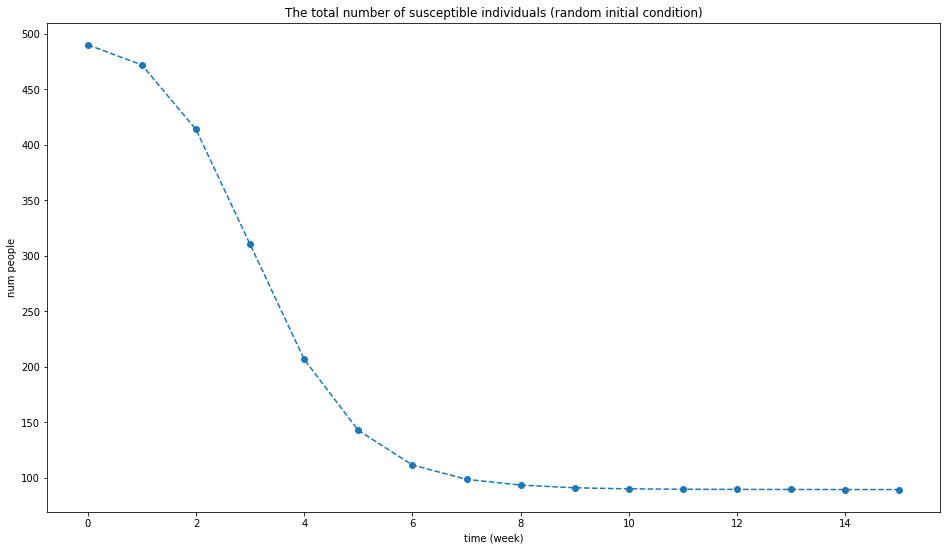

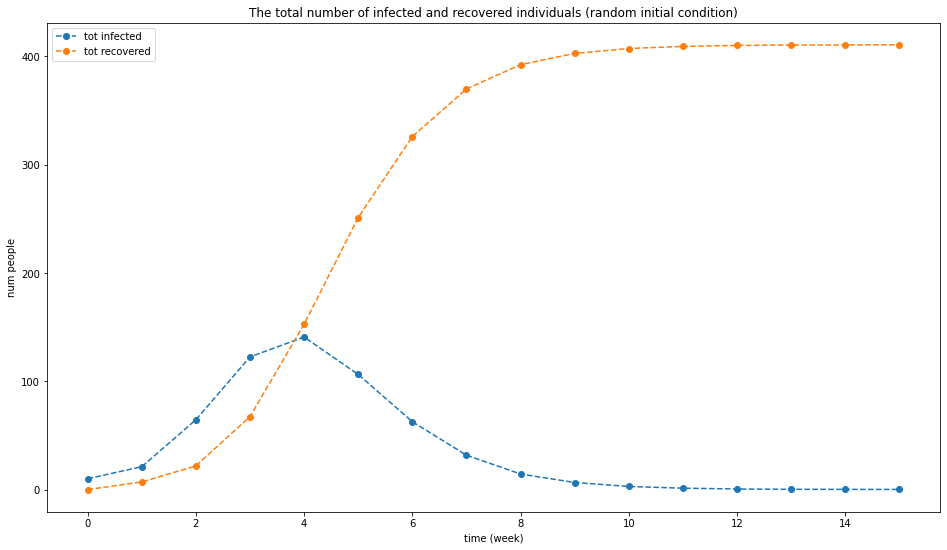

In [22]:
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
#ax.set_yticks(yint)
ax.set_title("The number of newly infected individuals (random initial condition)")
plt.savefig("new_inf_p2.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot avg sus',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
#ax.set_yticks(yint)
ax.set_title("The total number of susceptible individuals (random initial condition)")
plt.savefig("tot_sus_p2.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (random initial condition)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_p2.eps",format='eps')


## Realistic Initial Condition

In [29]:
sus_list = []
inf_list = []
rec_list = []
new_inf_list = []

k = 6
beta = 0.3
rho = 0.7
n=500
G2 = generate_graph(k,n, verbose=False)

init_state = [0]*n

inf_init = [0]+list(dict(G2.adjacency())[0].keys())[:7]
for i in inf_init:
    init_state[i] = 1

N = 100
for i in range(N):
    #print("Simulation #{}".format(i+1))
    weeks, newly_infected_list = sim_SIR_epidemic(G2, n_weeks=15, initial_states=init_state, random_sick=10, beta=beta, rho=rho) 
    susceptibles, infected, recovered = get_sir_count(weeks)
    #print('newly infected: {}\n'.format(newly_infected_list))
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    new_inf_list.append(newly_infected_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


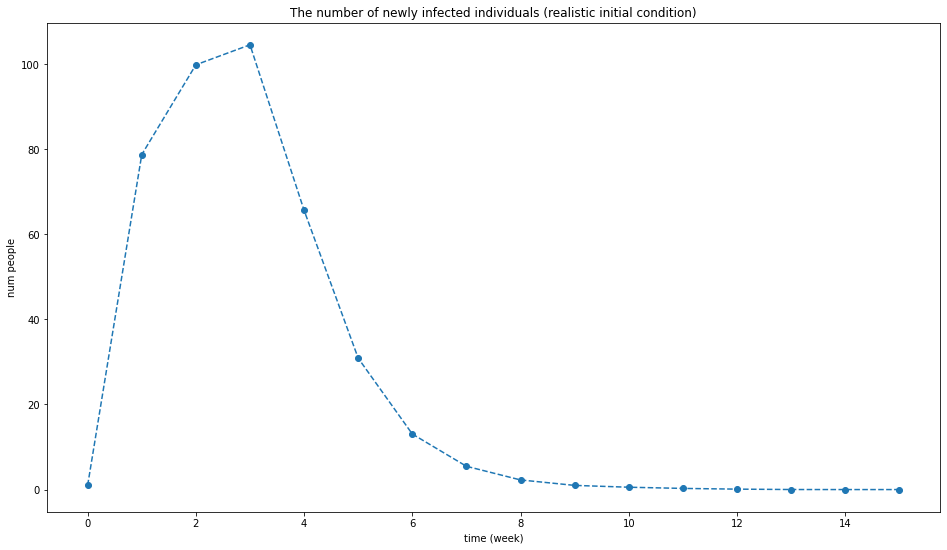

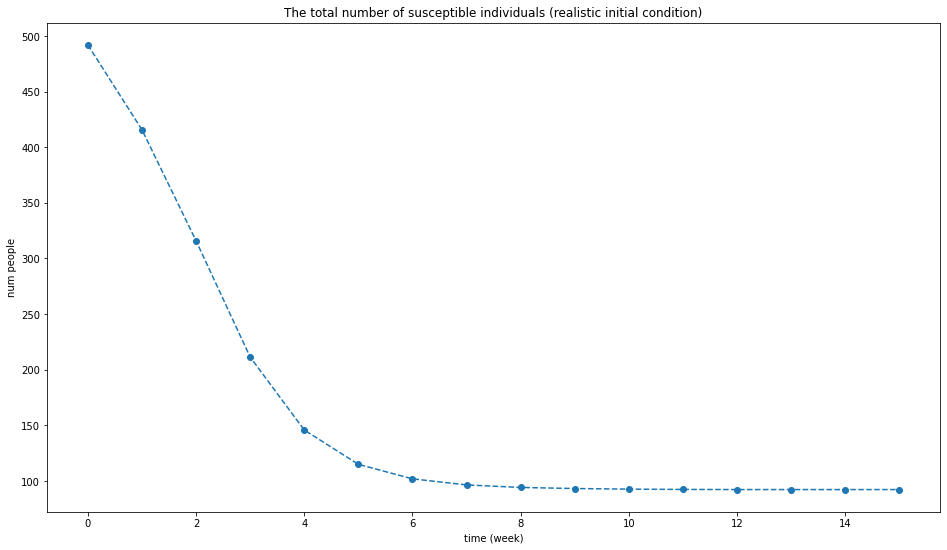

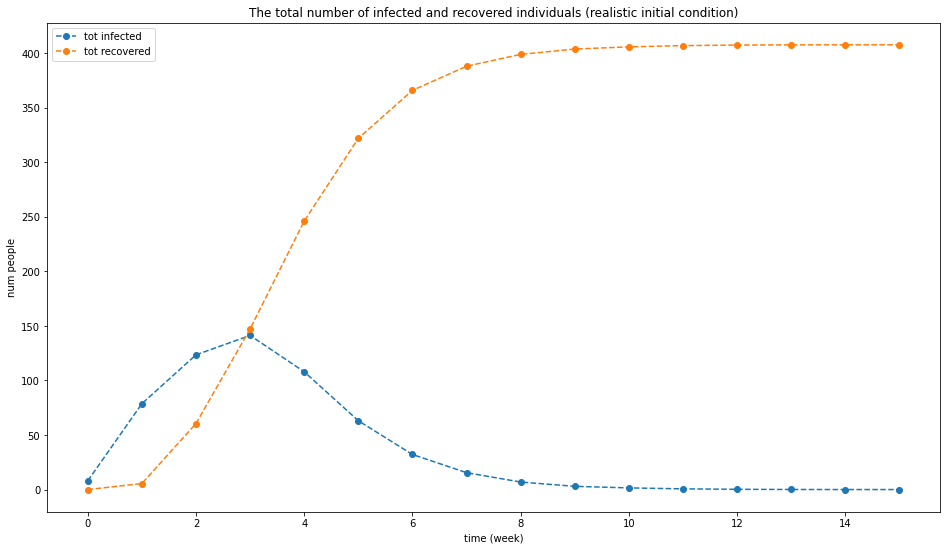

In [30]:
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
#ax.set_yticks(yint)
ax.set_title("The number of newly infected individuals (realistic initial condition)")
plt.savefig("new_inf_p2_real.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot avg sus',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
#ax.set_yticks(yint)
ax.set_title("The total number of susceptible individuals (realistic initial condition)")
plt.savefig("tot_sus_p2_real.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (realistic initial condition)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_p2_real.eps",format='eps')


# Problem 3

In [31]:
def sim_SIRV_epidemic(G, initial_infections, vacc, n_weeks = 5, initial_states = 'random', random_sick = 3, beta = 0.3, rho = 0.7, until_end = True):
    '''
    G: networkx.classes.graph.Graph, graph
    initial_infections: int, number of initally infected nodes
    vacc: list, the fraction of the total population vaccinated during each week
    n_weeks: int, number of simulation weeks
    initial_states: list, initial state of agents or default 'random' initialize sick people randomly
    random_sick: int, how many sick agents if initial state is randomly generated, default 3
    beta: float, the probability that the infection is spread from an infected individual to a susceptible one, default 0.3
    rho: float, the probability that an infected individual will recover, default 0.7
    vacc: list, vaccinated people percentage
        until_end: boolean, indicates whether the simulation continues until the end or finishes after we reach zero infected individuals
    '''

    # Number of people
    n_agents = len(G)

    A_ = [0,1,2,3] # 0-S, 1-I, 2-R, 3-V

    states = [0 for _ in range(n_agents)] # 0-S, 1-I, 2-R, 3-V

    if initial_states == 'random':
        choices = np.random.choice(G.nodes(),size = random_sick, replace= False)
        for i in choices:
            states[i] = 1
        initial_states = states.copy()

    old_states = initial_states.copy()

#     print('Initial states of agents: {}'.format(initial_states))

    W = nx.convert_matrix.to_numpy_matrix(G)

    weeks = []
    weeks.append(initial_states.copy())
    
 
    newly_infected_list = [initial_infections]
    
    unv_people = list(G.nodes) # unvaccinated people
    newly_vaccinated_list = [0]
    vacc2 = [vacc[i+1] - vacc[i] for i in range(len(vacc)-1)] 
    
    for week in range(n_weeks):  
        if not until_end:
            if not 1 in states:
                #print('No one is sick! \nGREAT SUCCESS!')
                break

        n_tobe_vac = int(n_agents*vacc2[week]/100) # number of people to be vaccinated in the current week
        tobe_vac_list = np.random.choice(unv_people, size = n_tobe_vac, replace = False) # people that are being vaccinated in the current week
        newly_vaccinated_list.append(n_tobe_vac)
        for agent in tobe_vac_list:
            old_states[agent] = 3
            states[agent] = 3
            unv_people.remove(agent) # remove agent from unvaccinated people's list
#         print("States: {}, \nWeek: {}".format(states, week+1))

        newly_infected = 0
        for agent in range(n_agents):
            # if S:
            if old_states[agent] == 0:
                ngh_states = np.squeeze(np.asarray(W[agent]))*old_states # get neighbors' statuses
                m = collections.Counter(ngh_states)[1] # count sick neighbors 

                if np.random.rand() < (1-(1-beta)**m):
                    states[agent] = 1 # get sick
                    newly_infected += 1
            # if I:
            elif old_states[agent] == 1:
                if np.random.rand() < rho:
                    states[agent] = 2 # get recovered
        
        weeks.append(states.copy())
        newly_infected_list.append(newly_infected)
        
        old_states = states.copy()
#         print(old_states)
    return weeks, newly_infected_list, newly_vaccinated_list
        # weeks = weeks[:5]

In [32]:
def get_sirv_count(weeks):
    '''
    weeks: list, list of states through weeks
    '''
    susceptibles = [collections.Counter(np.asarray(w))[0] for w in weeks]
    infected = [collections.Counter(np.asarray(w))[1] for w in weeks]
    recovered = [collections.Counter(np.asarray(w))[2] for w in weeks]
    vaccinated = [collections.Counter(np.asarray(w))[3] for w in weeks]
    #print('susceptibles: {}, \ninfected: {}, \nrecovered: {}, \nvaccinated: {}'.format(susceptibles, infected, recovered,vaccinated))
    return susceptibles, infected, recovered, vaccinated

In [33]:
sus_list = []
inf_list = []
rec_list = []
vac_list = []
new_inf_list = []
new_vac_list = []
k = 6
n = 500
beta = 0.3
rho = 0.7
n_weeks = 15

vacc_t = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
vacc = [0]
vacc.extend(vacc_t)

G3 = generate_graph(k,n, verbose=False)
N = 100
for i in range(N):
    #print("Simulation #{}".format(i+1))
    weeks, newly_infected_list, newly_vaccinated_list = sim_SIRV_epidemic(G3, 10, vacc, n_weeks=n_weeks, initial_states='random', random_sick=10, beta=beta, rho=rho, ) 
    susceptibles, infected, recovered, vaccinated = get_sirv_count(weeks)
    #print('newly infected: {}'.format(newly_infected_list))
    #print('newly vaxed: {}\n'.format(newly_vaccinated_list))
    
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    vac_list.append(vaccinated)
    
    new_inf_list.append(newly_infected_list)
    new_vac_list.append(newly_vaccinated_list)    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


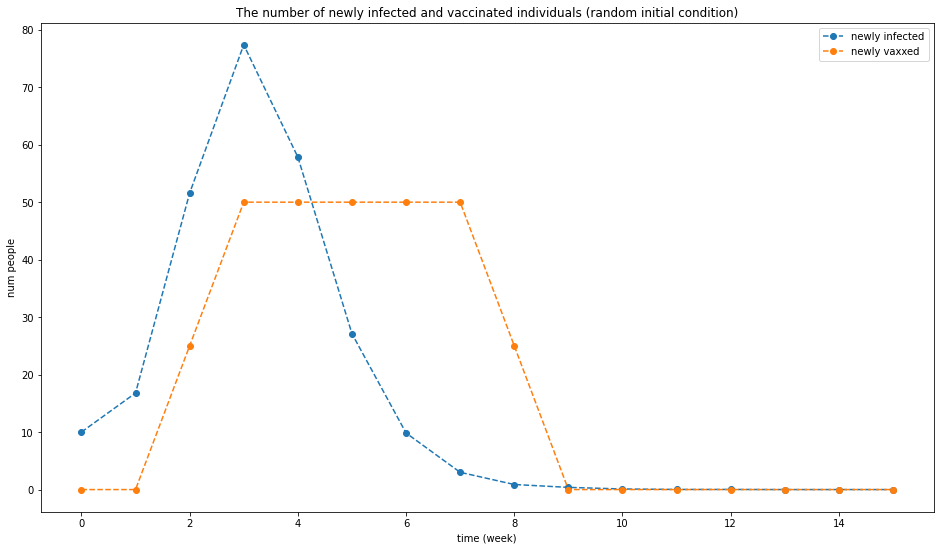

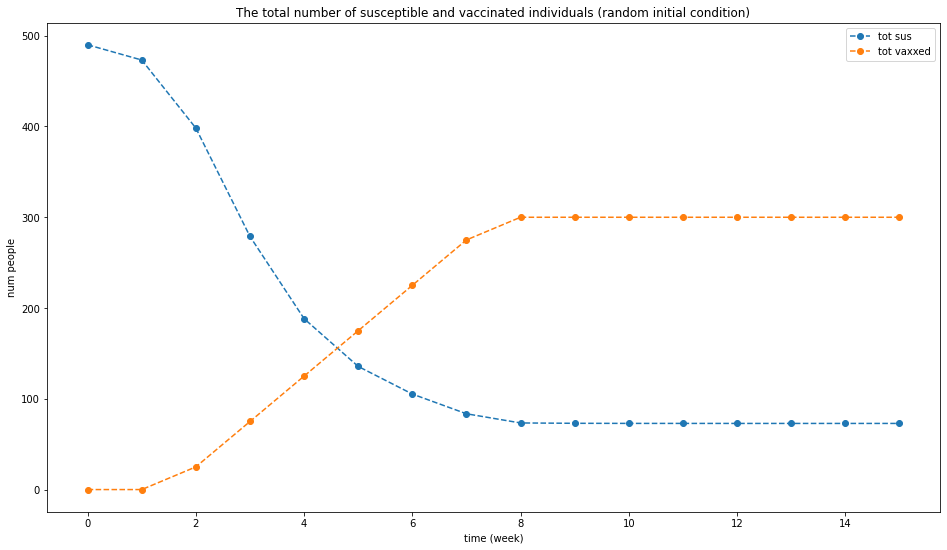

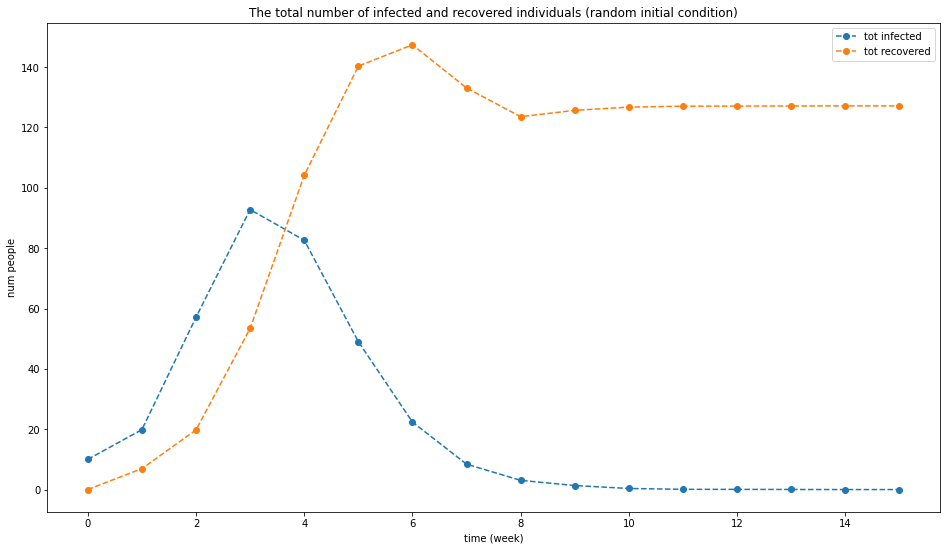

In [35]:
avg_new_vac = np.mean(np.array(new_vac_list), axis=0)
avg_vac = np.mean(np.array(vac_list), axis=0)
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.plot(avg_new_vac, label='newly vaxxed',linestyle='--', marker='o')

ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
#ax.set_yticks(yint)
ax.legend(loc='best')

ax.set_title("The number of newly infected and vaccinated individuals (random initial condition)")
plt.savefig("new_inf_p3.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot sus',linestyle='--', marker='o')
ax.plot(avg_vac, label='tot vaxxed',linestyle='--', marker='o')
ax.legend(loc='best')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
#ax.set_yticks(yint)
ax.set_title("The total number of susceptible and vaccinated individuals (random initial condition)")
plt.savefig("tot_sus_p3.eps",format='eps')
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(range(n_weeks+1),avg_inf, label='tot infected', linestyle='--', marker='o')
ax.plot(range(n_weeks+1),avg_rec, label='tot recovered', linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (random initial condition)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_p3.eps",format='eps')


# Problem 4

In [36]:
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]

 # we assume that during the week 0 nobody is vaccinated and
 # add 0'th week in order to calculate percentage of newly vaccinated people during week 15...
I0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
n_agents = 934 

k0 = 10 
beta0 = 0.3
rho0 = 0.6

dk = 1
dbeta = 0.1
drho = 0.1

In [37]:
def RMSE(I, I0):
    return np.sqrt(np.mean((np.array(I)-np.array(I0))**2))

In [41]:
def find_pand_params(n_agents = 934, k0 = 10, beta0 = 0.3, rho0 = 0.6,
                     dk_ = 1, dbeta_ = 0.1, drho_ = 0.1, p=0.5, graph_type = 'pref_attach', **kwargs):
    RMSE_list = []
    N = 10 # number of simulations
    
    k_opt = k0
    beta_opt = beta0
    rho_opt = rho0

    dk = dk_
    dbeta = dbeta_
    drho = drho_
    min_RMSE = np.inf

    opt_comb  = [k_opt, beta_opt, rho_opt]
    optimization_option = kwargs.get('opt_option', None)


    print("Initial hyperparameter combination: {}".format(opt_comb))

    iteration = 1
    while True: 
        print("Iteration {}".format(iteration))
        
        #print("Current best combination: {}".format(opt_comb))
        k = [k_opt, k_opt-dk, k_opt+dk]
        beta = [beta_opt, np.round(beta_opt-dbeta,2), np.round(beta_opt+dbeta,2)]
        rho = [rho_opt, np.round(rho_opt-drho, 2), np.round(rho_opt+drho, 2)]

        combs = []
        for i in range(len(k)):
            for j in range(len(beta)):
                for l in range(len(rho)):
                    combs.append([k[i], beta[j], rho[l]])

        for comb in combs:
            k = comb[0]
            beta = comb[1]
            rho = comb[2]
            

            
            
            if graph_type == 'pref_attach':
                G4 = generate_graph(k, n_agents)
            else:
                raise NotImplementedError("The graph model is not valid!")


            new_inf_list = []
            for i in range(N):
                _, newly_infected_list, _ = sim_SIRV_epidemic(G4, 1, vacc,
                                                              n_weeks=15, 
                                                              initial_states='random', 
                                                              random_sick=1, 
                                                              beta=beta, 
                                                              rho=rho) 
                #print('newly infected: {}'.format(newly_infected_list))

                new_inf_list.append(newly_infected_list.copy())
            
            I_pred = np.mean(np.array(new_inf_list), axis=0)
            #print(I_pred)
            RMSE_c = RMSE(I_pred, I0)
            if RMSE_c < min_RMSE:
                best_comb = comb
                min_RMSE = RMSE_c
            print('The Current Comb.: {}, RMSE: {}'.format(comb, RMSE_c))
        RMSE_list.append(min_RMSE)
        print('\nThe Current Best Comb.: {}, RMSE: {}'.format(best_comb, min_RMSE))


    #     print('RMSEs:', RMSE_list)

        if (best_comb == opt_comb):
            print('Convergence reached!')
            break
        opt_comb = best_comb.copy()
        if optimization_option == None:
            k_opt = best_comb[0]
            beta_opt = best_comb[1]
            rho_opt = best_comb[2]
        elif optimization_option == 'halving':
            if beta_opt == best_comb[1]:
                dbeta /= 2
            if rho_opt == best_comb[2]:
                drho /= 2
            k_opt = best_comb[0]
            beta_opt = best_comb[1]
            rho_opt = best_comb[2]
        iteration += 1
    return RMSE_list, opt_comb



In [42]:
RMSE_list, opt_comb = find_pand_params(opt_option='halving')

Initial hyperparameter combination: [10, 0.3, 0.6]
Iteration 1
The Current Comb.: [10, 0.3, 0.6], RMSE: 37.26508083984255
The Current Comb.: [10, 0.3, 0.5], RMSE: 32.59538886100302
The Current Comb.: [10, 0.3, 0.7], RMSE: 35.213278745382404
The Current Comb.: [10, 0.2, 0.6], RMSE: 18.21098569545317
The Current Comb.: [10, 0.2, 0.5], RMSE: 9.066593902894295
The Current Comb.: [10, 0.2, 0.7], RMSE: 7.731995214690708
The Current Comb.: [10, 0.4, 0.6], RMSE: 70.04001534837067
The Current Comb.: [10, 0.4, 0.5], RMSE: 65.84742781612658
The Current Comb.: [10, 0.4, 0.7], RMSE: 57.61515100214526
The Current Comb.: [9, 0.3, 0.6], RMSE: 34.561702070355274
The Current Comb.: [9, 0.3, 0.5], RMSE: 43.049767711336145
The Current Comb.: [9, 0.3, 0.7], RMSE: 33.78029196143811
The Current Comb.: [9, 0.2, 0.6], RMSE: 11.842138742642733
The Current Comb.: [9, 0.2, 0.5], RMSE: 4.74453633140268
The Current Comb.: [9, 0.2, 0.7], RMSE: 9.10078980089091
The Current Comb.: [9, 0.4, 0.6], RMSE: 40.7596154299816

In [86]:
k = opt_comb[0]
beta = opt_comb[1]
rho = opt_comb[2]

G4 = generate_graph(k, n_agents, verbose=False)
N = 100
sus_list = []
inf_list = []
rec_list = []
vac_list = []
new_inf_list = []
new_vac_list = []
for n in range(N):
    #print("Simulation #{}".format(n+1))
    weeks, newly_infected_list, newly_vaccinated_list = sim_SIRV_epidemic(G4, 1, vacc,
                                                                          n_weeks=15, 
                                                                          initial_states='random', 
                                                                          random_sick=1, 
                                                                          beta=beta, 
                                                                          rho=rho) 
    susceptibles, infected, recovered, vaccinated = get_sirv_count(weeks)
    #print('newly infected: {}'.format(newly_infected_list))
#     print('newly vaxed: {}\n'.format(newly_vaccinated_list))
    
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    vac_list.append(vaccinated)
    
    new_inf_list.append(newly_infected_list)
    new_vac_list.append(newly_vaccinated_list)    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


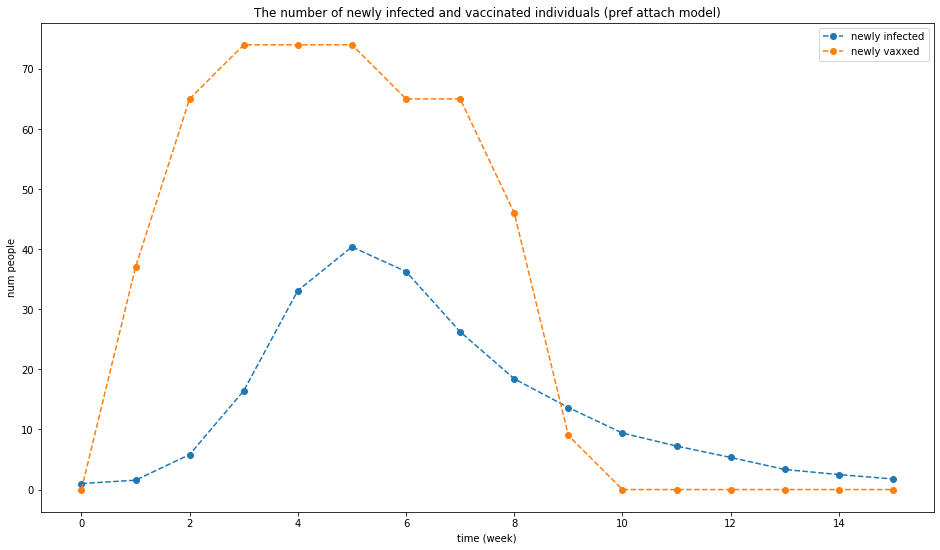

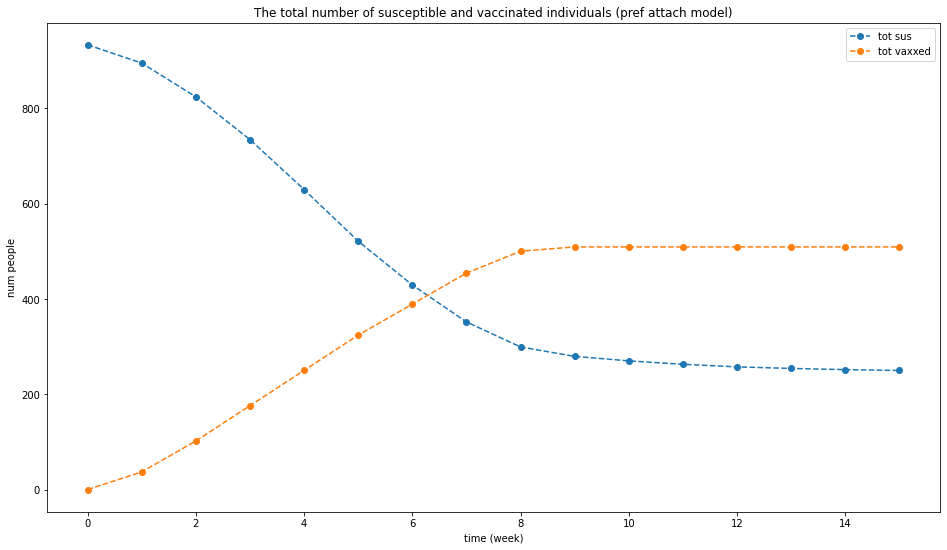

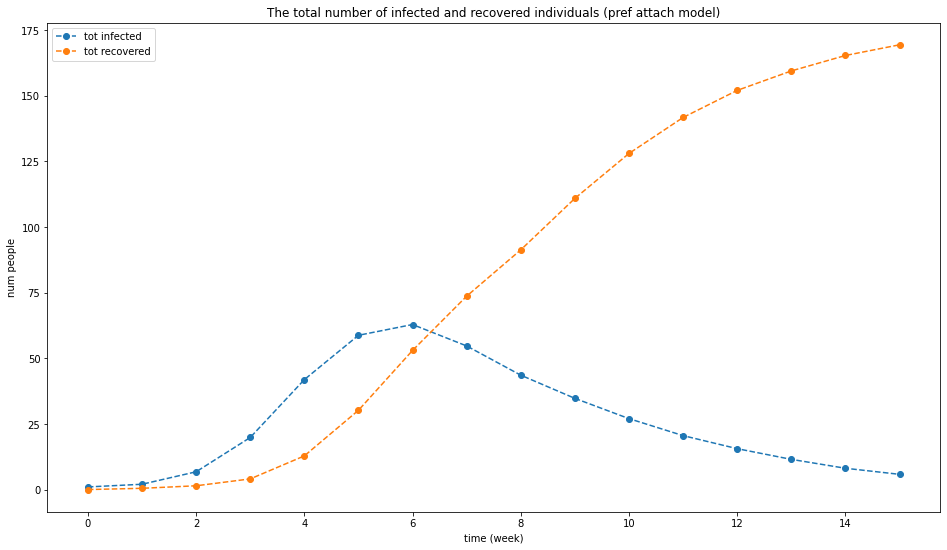

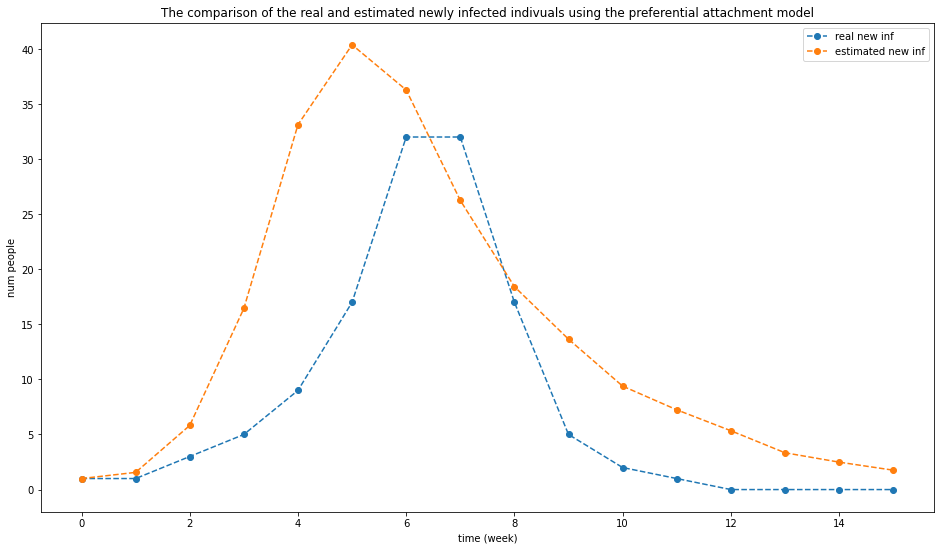

In [87]:
avg_new_vac = np.mean(np.array(new_vac_list), axis=0)
avg_vac = np.mean(np.array(vac_list), axis=0)
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.plot(avg_new_vac, label='newly vaxxed',linestyle='--', marker='o')
ax.legend(loc='best')

ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
#ax.set_yticks(yint)
ax.set_title("The number of newly infected and vaccinated individuals (pref attach model)")
plt.savefig("new_inf_p4.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot sus',linestyle='--', marker='o')
ax.plot(avg_vac, label='tot vaxxed',linestyle='--', marker='o')
ax.legend(loc='best')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
#ax.set_yticks(yint)
ax.legend(loc='best')
ax.set_title("The total number of susceptible and vaccinated individuals (pref attach model)")
plt.savefig("tot_sus_p4.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (pref attach model)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_p4.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(I0, label='real new inf', linestyle='--', marker='o')
ax.plot(avg_new_inf, label='estimated new inf', linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The comparison of the real and estimated newly infected indivuals using the preferential attachment model")
ax.legend(loc='best')
plt.savefig("real_data_comp_p4.eps",format='eps')

# Problem 5

In [88]:
def watts_strogats_model_sim(n_agents = 934, k0 = 10, beta0 = 0.3, rho0 = 0.6,
                     dk_ = 1, dbeta_ = 0.1, drho_ = 0.1, restart_iters=2, **kwargs):
    RMSE_list = []
    N = 10 # number of simulations
    
    k_opt = k0
    beta_opt = beta0
    rho_opt = rho0

    dk = dk_
    dbeta = dbeta_
    drho = drho_
    min_RMSE = np.inf

    opt_comb  = [k_opt, beta_opt, rho_opt]
    optimization_option = kwargs.get('opt_option', None)
    if optimization_option == 'restart':
        res_iter = 0

    print("Initial hyperparameter combination: {}".format(opt_comb))

    iteration = 1
    while True: 
        print("Iteration {}".format(iteration))    
        #print("Current best combination: {}".format(opt_comb))
        k = [k_opt, k_opt-dk, k_opt+dk]
        beta = [beta_opt, np.round(beta_opt-dbeta,2), np.round(beta_opt+dbeta,2)]
        rho = [rho_opt, np.round(rho_opt-drho, 2), np.round(rho_opt+drho, 2)]

        combs = []
        for i in range(len(k)):
            for j in range(len(beta)):
                for l in range(len(rho)):
                    combs.append([k[i], beta[j], rho[l]])

        for comb in combs:
            k = comb[0]
            beta = comb[1]
            rho = comb[2]

            G5 = ws(n_agents, k, 0.5)

            new_inf_list = []
            for i in range(N):
                _, newly_infected_list, _ = sim_SIRV_epidemic(G5, 1, vacc,
                                                              n_weeks=15, 
                                                              initial_states='random', 
                                                              random_sick=1, 
                                                              beta=beta, 
                                                              rho=rho) 
                #print('newly infected: {}'.format(newly_infected_list))
                new_inf_list.append(newly_infected_list.copy())
            
            I_pred = np.mean(np.array(new_inf_list), axis=0)
            #print(I_pred)
            RMSE_c = RMSE(I_pred, I0)
            if RMSE_c < min_RMSE:
                best_comb = comb
                min_RMSE = RMSE_c
            print('The Current Comb.: {}, RMSE: {}'.format(comb, RMSE_c))
        RMSE_list.append(min_RMSE)
        print('\nThe Current Best Comb.: {}, RMSE: {}'.format(best_comb, min_RMSE))

        if (best_comb == opt_comb):
            if optimization_option == 'restart' and res_iter<restart_iters:
                res_iter += 1
                dbeta /= 2
                drho /= 2
            else:    
                print('Convergence reached!')
                break
        opt_comb = best_comb.copy()

        if optimization_option == None:
            k_opt = best_comb[0]
            beta_opt = best_comb[1]
            rho_opt = best_comb[2]

        elif optimization_option == 'halving':
            if beta_opt == best_comb[1]:
                dbeta /= 2
            if rho_opt == best_comb[2]:
                drho /= 2
            k_opt = best_comb[0]
            beta_opt = best_comb[1]
            rho_opt = best_comb[2]


        iteration += 1
    return RMSE_list, opt_comb



In [89]:
vacc = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]

 # we assume that during the week 0 nobody is vaccinated and
 # add 0'th week in order to calculate percentage of newly vaccinated people during week 15...
I0 = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
n_agents = 934 

k0 = 10 
beta0 = 0.3
rho0 = 0.6

dk = 1
dbeta = 0.1
drho = 0.1

In [208]:
RMSE_list, opt_comb = watts_strogats_model_sim(k0 = k0, beta0=beta0, rho0=rho0, dk_=dk,dbeta_=dbeta, drho_=drho, opt_option='restart')

In [209]:

k = opt_comb[0]
beta = opt_comb[1]
rho = opt_comb[2]

G5 = ws(n_agents, k, 0.5)
N = 100
sus_list = []
inf_list = []
rec_list = []
vac_list = []
new_inf_list = []
new_vac_list = []
for n in range(N):
    #print("Simulation #{}".format(n+1))
    weeks, newly_infected_list, newly_vaccinated_list = sim_SIRV_epidemic(G5, 
                                                                          1, vacc,
                                                                          n_weeks=15, 
                                                                          initial_states='random', 
                                                                          random_sick=1, 
                                                                          beta=beta, 
                                                                          rho=rho) 
    susceptibles, infected, recovered, vaccinated = get_sirv_count(weeks)
    #print('newly infected: {}'.format(newly_infected_list))
#     print('newly vaxed: {}\n'.format(newly_vaccinated_list))
    
    sus_list.append(susceptibles)
    inf_list.append(infected)
    rec_list.append(recovered)
    vac_list.append(vaccinated)
    
    new_inf_list.append(newly_infected_list)
    new_vac_list.append(newly_vaccinated_list)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


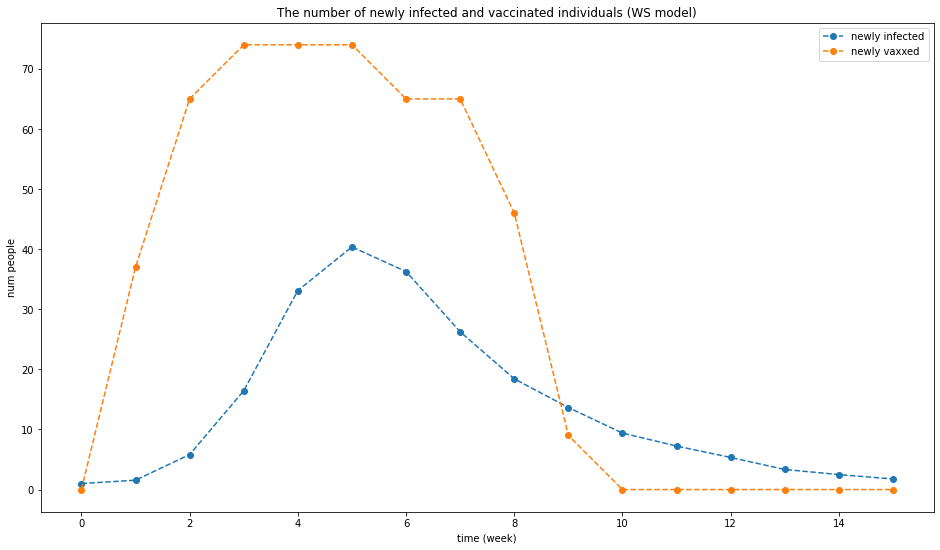

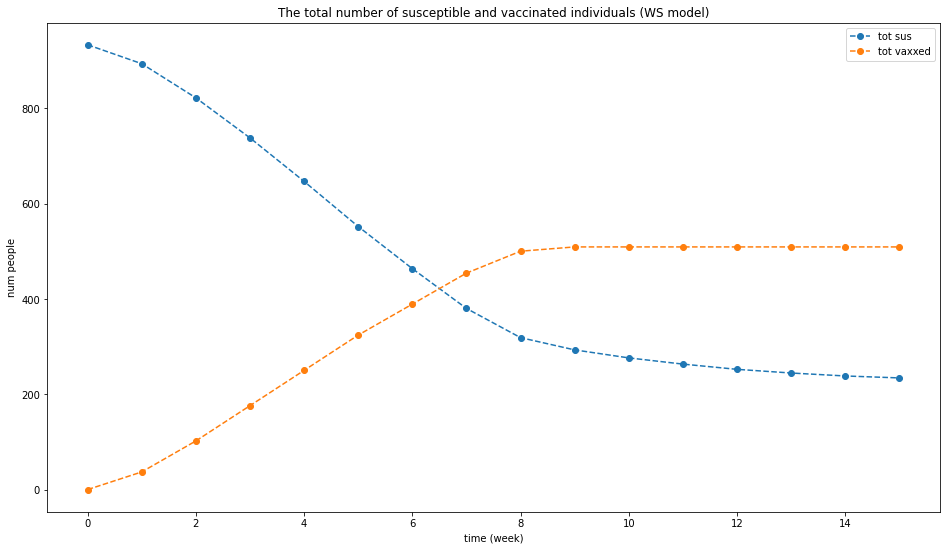

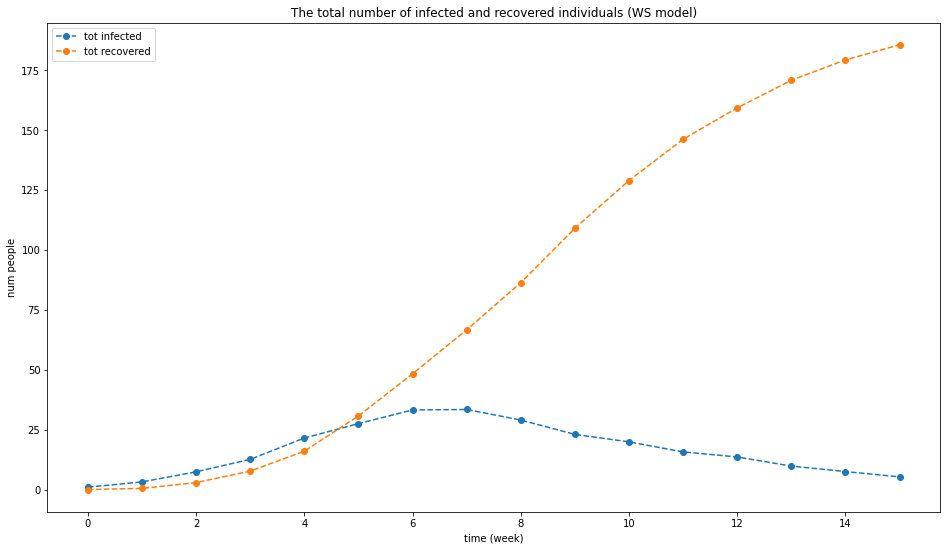

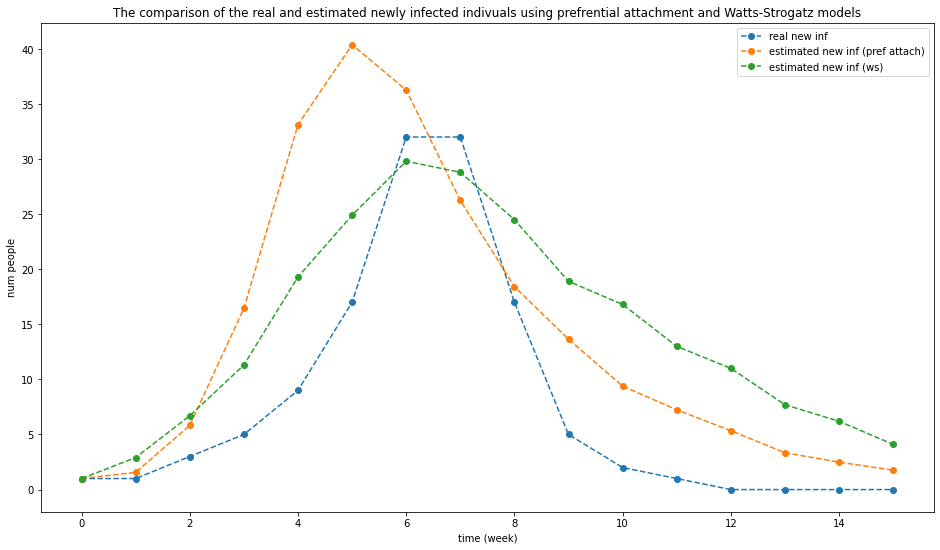

In [207]:
avg_new_vac = np.mean(np.array(new_vac_list), axis=0)
avg_vac = np.mean(np.array(vac_list), axis=0)
avg_sus = np.mean(np.array(sus_list), axis=0)
avg_inf = np.mean(np.array(inf_list), axis=0)
avg_rec = np.mean(np.array(rec_list), axis=0)
avg_new_inf_ws = np.mean(new_inf_list, axis=0)
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_new_inf, label='newly infected',linestyle='--', marker='o')
ax.plot(avg_new_vac, label='newly vaxxed',linestyle='--', marker='o')
ax.legend(loc='best')

ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_new_inf)), math.ceil(max(avg_new_inf))+1)
#ax.set_yticks(yint)
ax.set_title("The number of newly infected and vaccinated individuals (WS model)")
plt.savefig("new_inf_p5.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_sus, label='tot sus',linestyle='--', marker='o')
ax.plot(avg_vac, label='tot vaxxed',linestyle='--', marker='o')
ax.legend(loc='best')
ax.set(xlabel='time (week)', ylabel='num people')
yint = range(int(min(avg_sus)), math.ceil(max(avg_sus))+1)
#ax.set_yticks(yint)
ax.legend(loc='best')
ax.set_title("The total number of susceptible and vaccinated individuals (WS model)")
plt.savefig("tot_sus_p5.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(avg_inf, label='tot infected',linestyle='--', marker='o')
ax.plot(avg_rec, label='tot recovered',linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The total number of infected and recovered individuals (WS model)")
ax.legend(loc='best')
plt.savefig("tot_rec_inf_p5.eps",format='eps')

fig, ax= plt.subplots(figsize=(16,9))
ax.plot(I0, label='real new inf', linestyle='--', marker='o')
ax.plot(avg_new_inf, label='estimated new inf (pref attach)', linestyle='--', marker='o')
ax.plot(avg_new_inf_ws, label='estimated new inf (ws)', linestyle='--', marker='o')
ax.set(xlabel='time (week)', ylabel='num people')
ax.set_title("The comparison of the real and estimated newly infected indivuals using prefrential attachment and Watts-Strogatz models")
ax.legend(loc='best')
plt.savefig("real_data_comp_p5.eps",format='eps')